# Polarization example - azimuthal scattering angle distribution (ASAD) method

This notebook fits the polarization fraction and angle of a Data Challenge 3 GRB (GRB 080802386) simulated using MEGAlib and combined with albedo photon background. It's assumed that the start time, duration, localization, and spectrum of the GRB are already known. The GRB was simulated with 80% polarization at an angle of 90 degrees in the IAU convention, and was 20 degrees off-axis. A detailed description of the ASAD method, which is the approach used here to fit the polarization, is available on the [Data Challenge repository](https://github.com/cositools/cosi-data-challenges/tree/main/polarization). 

In [9]:
from cosipy import UnBinnedData
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.polarization.conventions import MEGAlibRelativeX, MEGAlibRelativeY, MEGAlibRelativeZ, IAUPolarizationConvention
from cosipy.polarization.polarization_asad import PolarizationASAD
from cosipy.threeml.custom_functions import Band_Eflux
from astropy.time import Time
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from astropy import units as u
from scoords import SpacecraftFrame
from cosipy.util import fetch_wasabi_file
from pathlib import Path

### Download and read in data

This will download the files needed to run this notebook. If you have already downloaded these files, you can skip this.

Download the unbinned data (660.58 KB)

In [ ]:
fetch_wasabi_file('COSI-SMEX/cosipy_tutorials/polarization_fit/grb_background.fits.gz')

Download the polarization response (1.35 GB). This needs to be unzipped before running the rest of the notebook

In [ ]:
fetch_wasabi_file('COSI-SMEX/DC3/Data/Responses/ResponseContinuum.o3.pol.e200_10000.b4.p12.relx.s10396905069491.m420.filtered.nonsparse.binnedpolarization.11D_nside8.area.good_chunks.h5.zip', unzip = True, checksum = '')

Download the orientation file (1.10 GB)

In [ ]:
fetch_wasabi_file('COSI-SMEX/DC3/Data/Orientation/DC3_final_530km_3_month_with_slew_1sbins_GalacticEarth_SAA.ori')

Read in the unbinned data, which is a GRB placed within albedo photon background. A time cut is done for the duration of the GRB to produce the GRB+background data to fit. The time intervals before and after the GRB are used to produce a background model. An energy cut is applied to both the data and background model to match the energy range of the detector response. Binned data can also be used for the ASAD method for both the data and background model.

In [ ]:
data_path = Path("") # Update to your path
grb_background = UnBinnedData(data_path/'grb.yaml')
grb_background.select_data_time(unbinned_data=data_path/'grb_background.fits.gz', output_name=data_path/'grb_background_source_interval') 
grb_background.select_data_energy(200., 10000., output_name=data_path/'grb_background_source_interval_energy_cut', unbinned_data=data_path/'grb_background_source_interval.fits.gz')
data = grb_background.get_dict_from_fits(data_path/'grb_background_source_interval_energy_cut.fits.gz')

background_before = UnBinnedData(data_path/'background_before.yaml')
background_before.select_data_time(unbinned_data=data_path/'grb_background.fits.gz', output_name=data_path/'background_before')
background_before.select_data_energy(200., 10000., output_name=data_path/'background_before_energy_cut', unbinned_data=data_path/'background_before.fits.gz')
background_1 = background_before.get_dict_from_fits(data_path/'background_before_energy_cut.fits.gz')

background_after = UnBinnedData(data_path/'background_after.yaml') # e.g. background_after.yaml
background_after.select_data_time(unbinned_data=data_path/'grb_background.fits.gz', output_name=data_path/'background_after')
background_after.select_data_energy(200., 10000., output_name=data_path/'background_after_energy_cut', unbinned_data=data_path/'background_after.fits.gz')
background_2 = background_after.get_dict_from_fits(data_path/'background_after_energy_cut.fits.gz')

background = [background_1, background_2]

Define the path to the detector response and read in the orientation file. The orientation is cut down to the time interval of the source.

In [ ]:
response_file = data_path/'ResponseContinuum.o3.pol.e200_10000.b4.p12.relx.s10396905069491.m420.filtered.nonsparse.binnedpolarization.11D_nside8.area.good_chunks.h5' # e.g. ResponseContinuum.o3.pol.e200_10000.b4.p12.s10396905069491.m441.filtered.nonsparse.binnedpolarization.11D_nside8.area.h5

sc_orientation = SpacecraftFile.parse_from_file(data_path/'DC3_final_530km_3_month_with_slew_1sbins_GalacticEarth_SAA.ori') # e.g. DC3_final_530km_3_month_with_slew_1sbins_GalacticEarth_SAA.ori
sc_orientation = sc_orientation.source_interval(Time(1835493492.2, format = 'unix'), Time(1835493492.8, format = 'unix'))

Define the GRB position and spectrum.

In [15]:
source_direction = SkyCoord(l=23.53, b=-53.44, frame='galactic', unit=u.deg)

a = 100. * u.keV
b = 10000. * u.keV
alpha = -0.7368949
beta = -2.095031
ebreak = 622.389 * u.keV
K = 300. / u.cm / u.cm / u.s

spectrum = Band_Eflux(a = a.value,
                      b = b.value,
                      alpha = alpha,
                      beta = beta,
                      E0 = ebreak.value,
                      K = K.value)

spectrum.a.unit = a.unit
spectrum.b.unit = b.unit
spectrum.E0.unit = ebreak.unit
spectrum.K.unit = K.unit

### Polarization fit in ICRS frame

Define the azimuthal scattering angle bin edges, and create the polarization object. A number of steps are done when this object is created:
- Creates ASADs for the GRB+background data and background model, and subtracts the background ASAD from the GRB+background ASAD to produce an ASAD for the GRB only
- Convolves the GRB position and spectrum with the response to produce an unpolarized ASAD and 100% polarized ASADs for each polarization angle bin
- Corrects for instrumental effects by dividing the GRB only and 100% polarized ASADs by the unpolarized ASAD
- Fits a sinusoid to the 100% polarized ASADs to determine the $\mu_{100}$, or the modulation of a 100% polarized source. This is used later on to convert the amplitude of the sinusoid fit to the GRB ASAD to a polarization fraction

The ASADs are automatically calculated in the IAU convention.

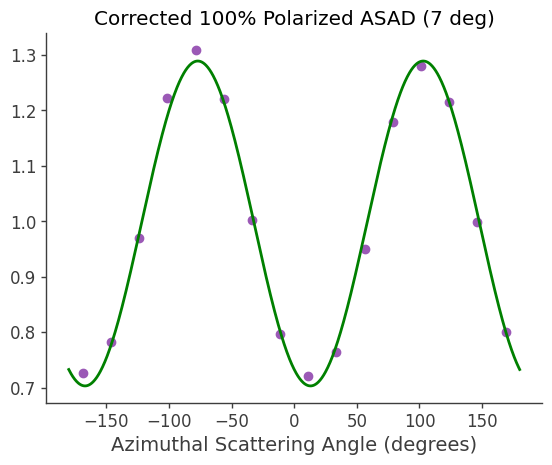

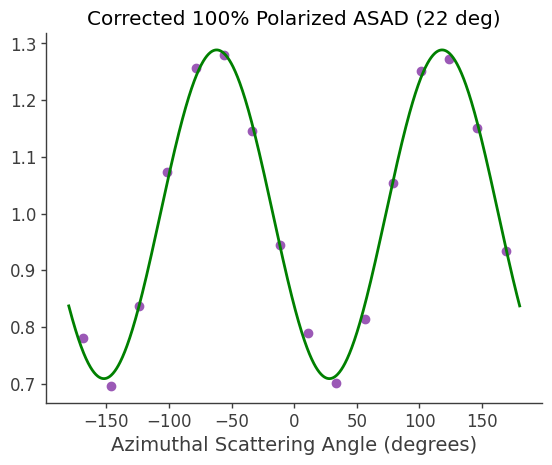

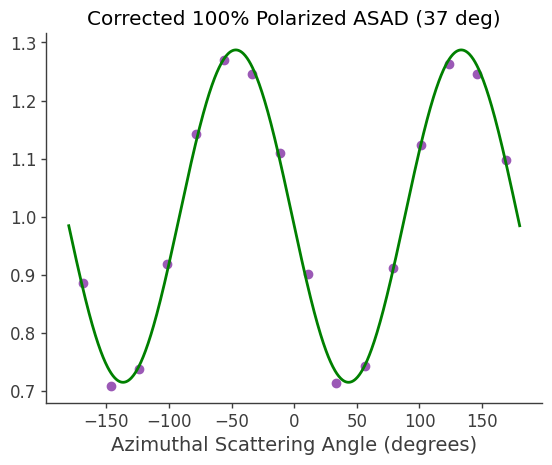

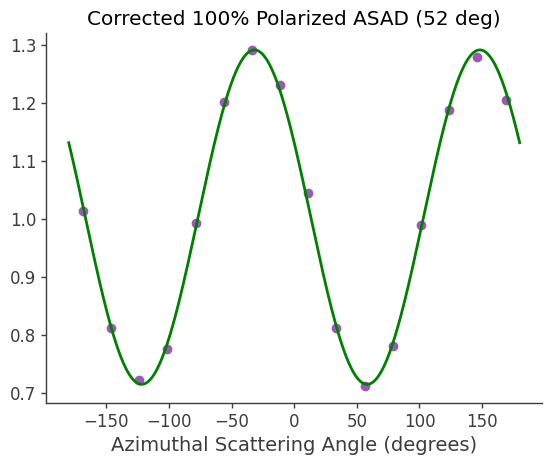

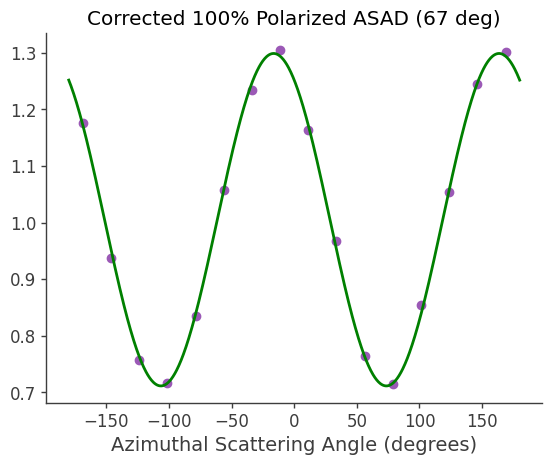

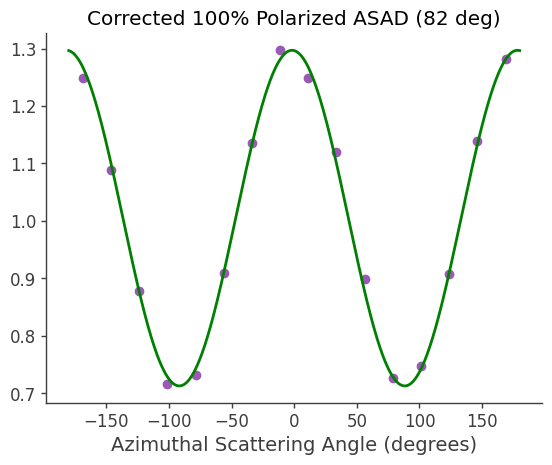

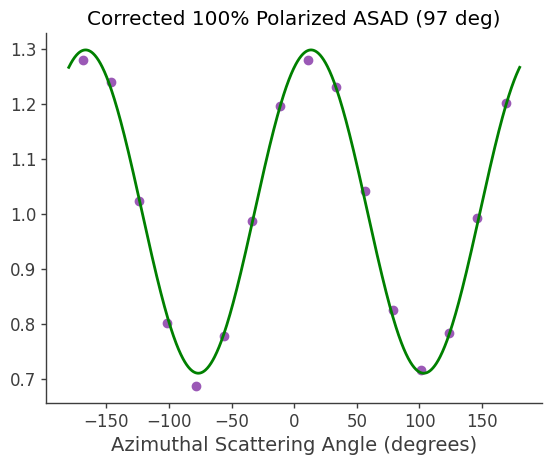

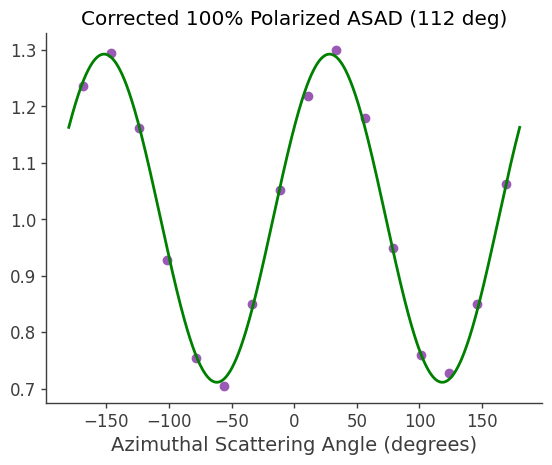

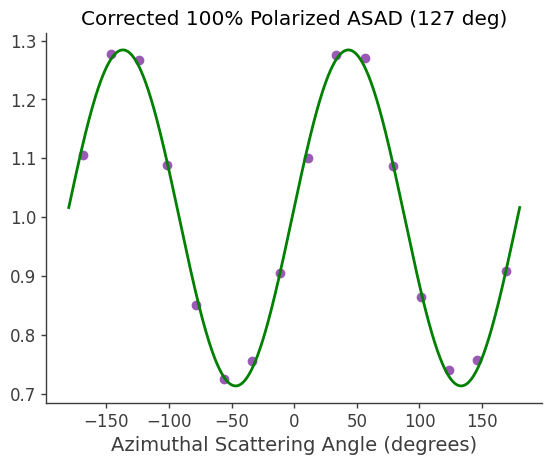

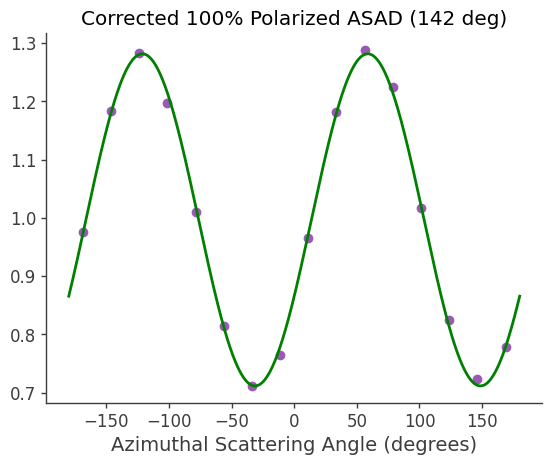

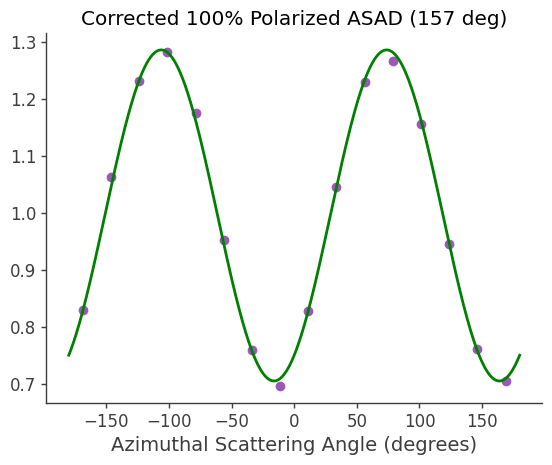

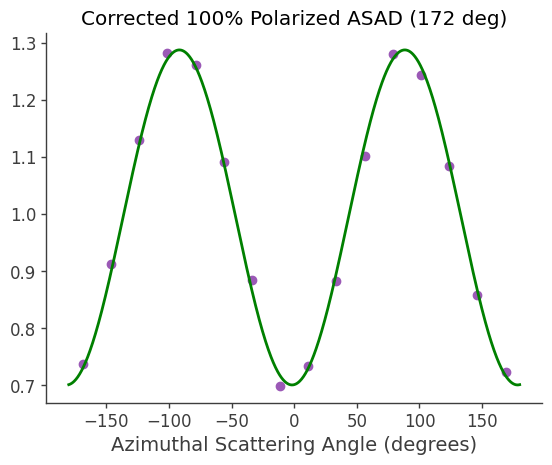

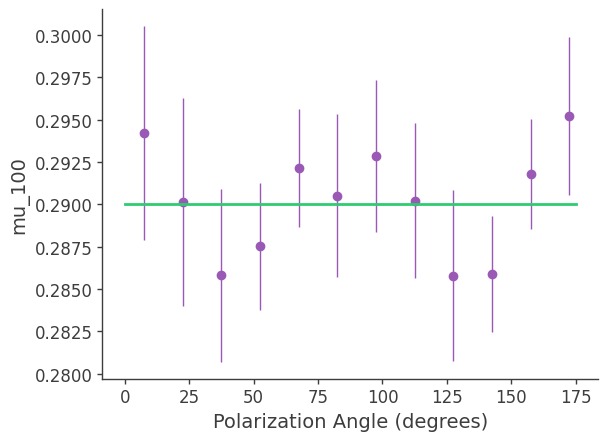

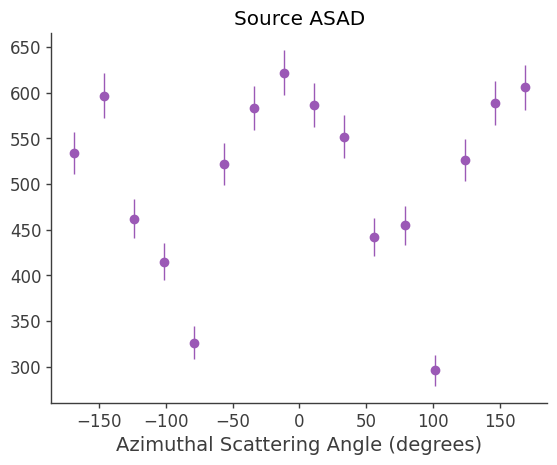

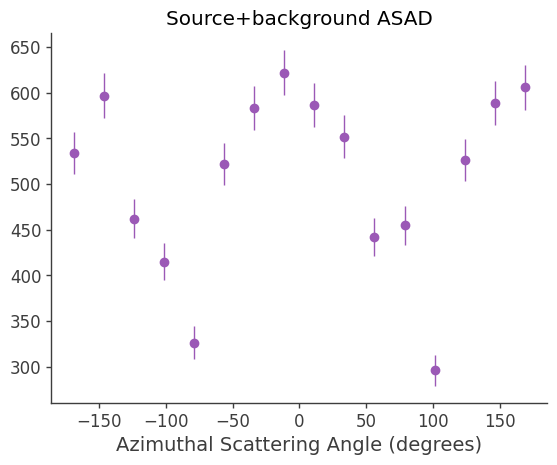

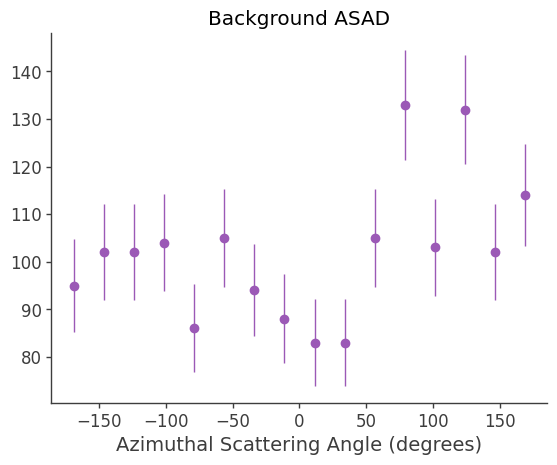

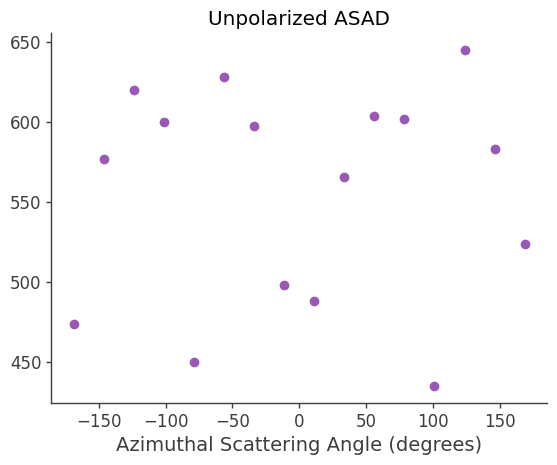

In [ ]:
asad_bin_edges = Angle(np.linspace(-np.pi, np.pi, 17), unit=u.rad)

grb_polarization = PolarizationASAD(source_direction, spectrum, asad_bin_edges, data, background, sc_orientation, response_file, response_convention='RelativeX', show_plots=True)

Perform the fit in the ICRS frame. A sinusoid is fit to the GRB ASAD, and the amplitude and phase are used to determine the polarization fraction and angle, respectively. Because the polarization angles are distributed uniformly within the polarization angle bins of the response, and the bins are coarse, the $\mu_{100}$ is underestimated, causing the fitted polarization fraction of the source to be overestimated.

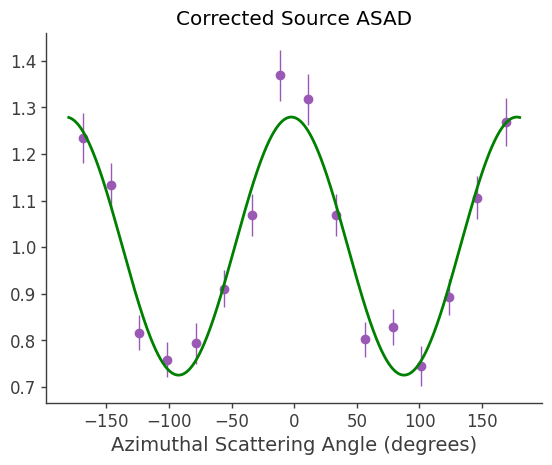

Best fit polarization fraction: 0.953 +/- 0.073
Minimum detectable polarization: 0.164
Best fit polarization angle (IAU convention): 87.668 +/- 1.987


In [19]:
polarization_icrs_fit = grb_polarization.fit(show_plots=True)

print('Best fit polarization fraction:', round(polarization_icrs_fit['fraction'], 3), '+/-', round(polarization_icrs_fit['fraction uncertainty'], 3))
print('Minimum detectable polarization:', round(grb_polarization._mdp, 3))
print('Best fit polarization angle (IAU convention):', round(polarization_icrs_fit['angle'].angle.degree, 3), '+/-', round(polarization_icrs_fit['angle uncertainty'].degree, 3))


### Polarization fit in spacecraft coordinates

For short duration sources, such as this short GRB, the spacecraft does not move much, allowing the fit to also be done in spacecraft coordinates. This cell determines the spacecraft attitude at the beginning of the GRB and transform the source position to the spacecraft frame. Then, the polarization object is generated with the convention for the fit specified as the same convention used to generate the detector response, which is RelativeZ in this case. The ASADs are now generated in the spacecraft frame, instead of the ICRS frame as they were above.


The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!
The response must have the same polarization convention as the provided polarization angle, or the result will be incorrect!


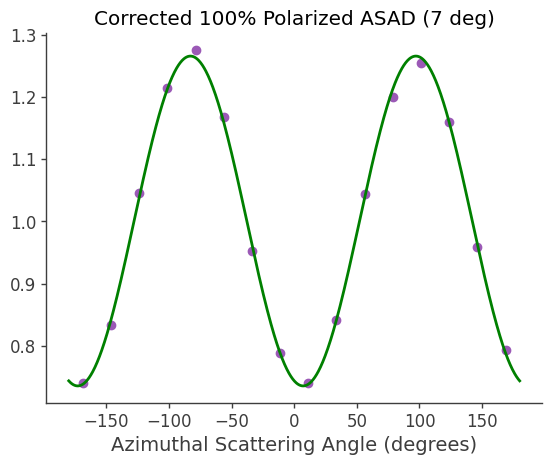

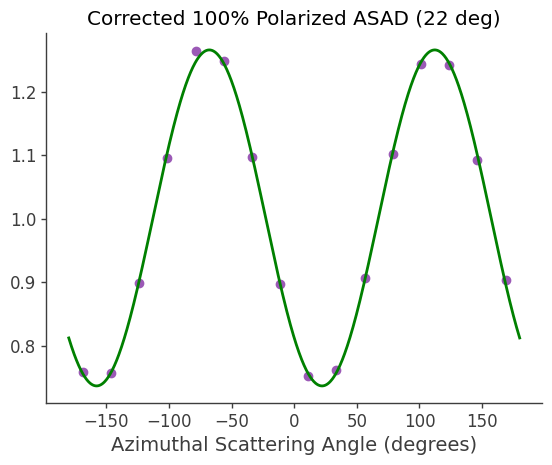

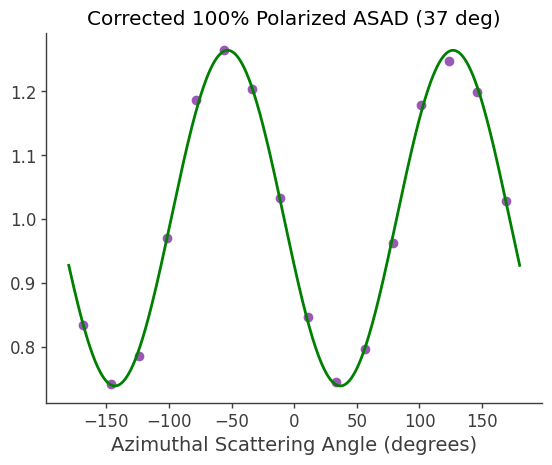

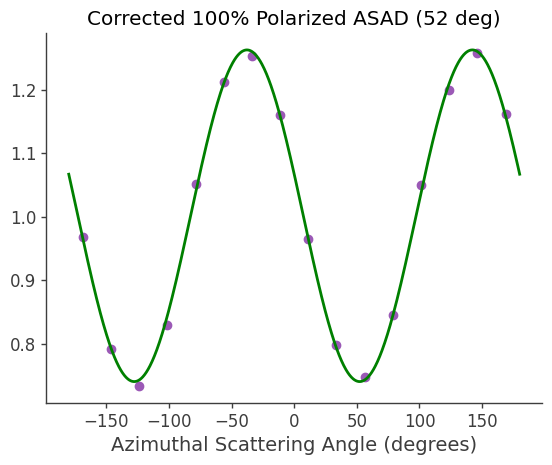

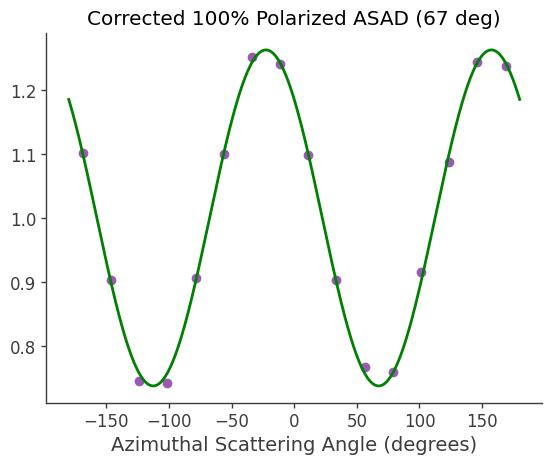

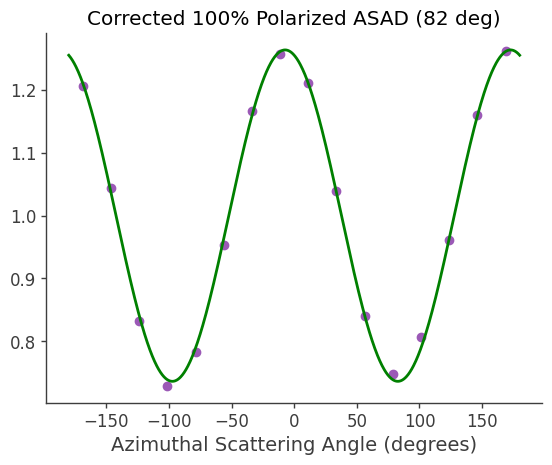

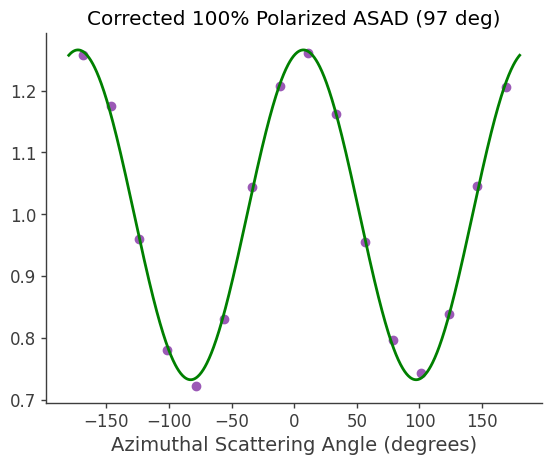

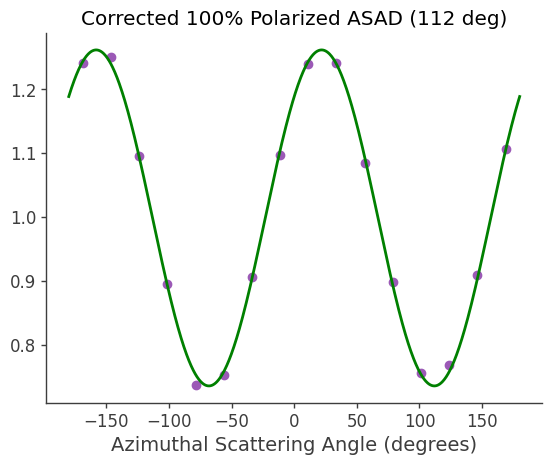

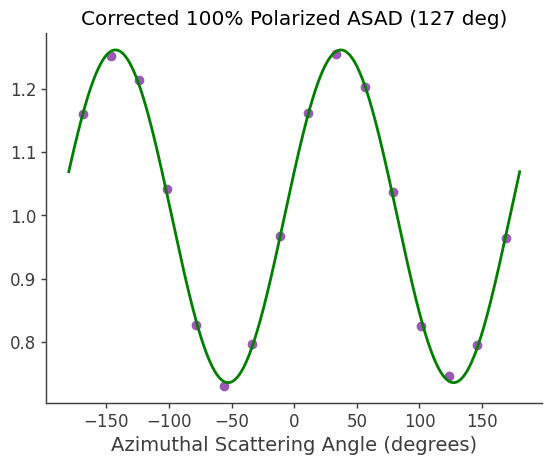

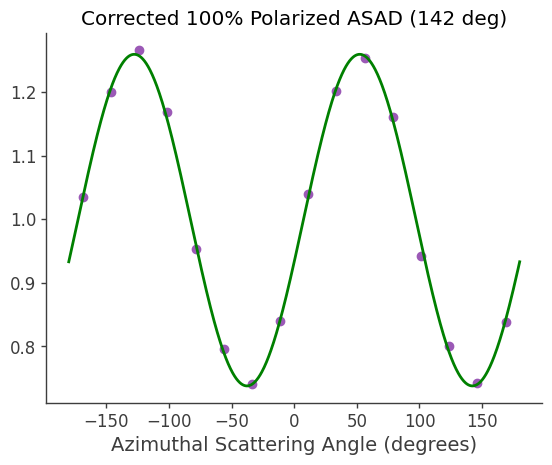

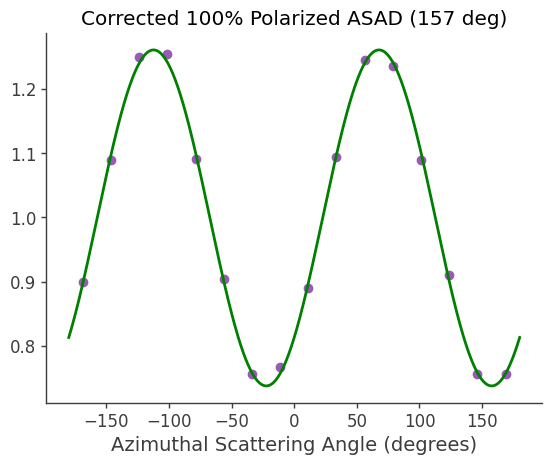

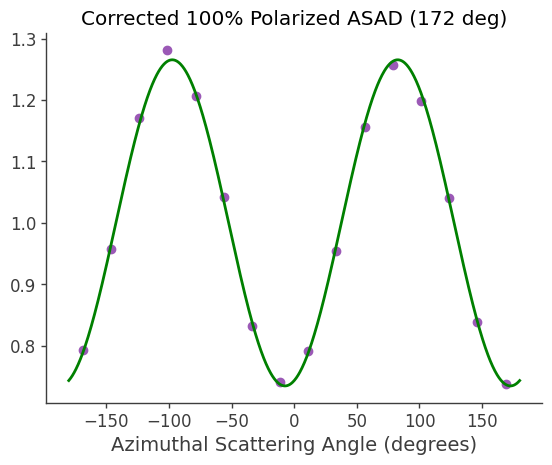

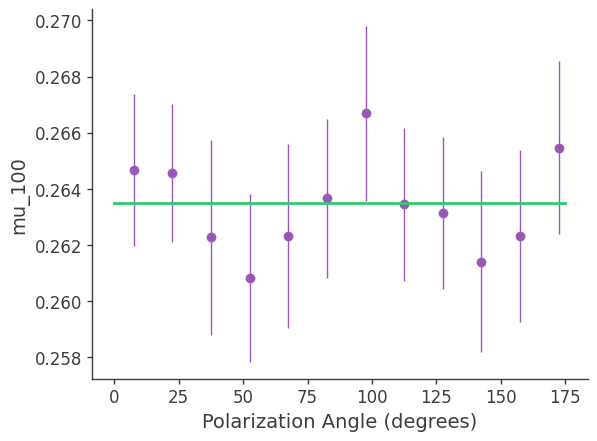

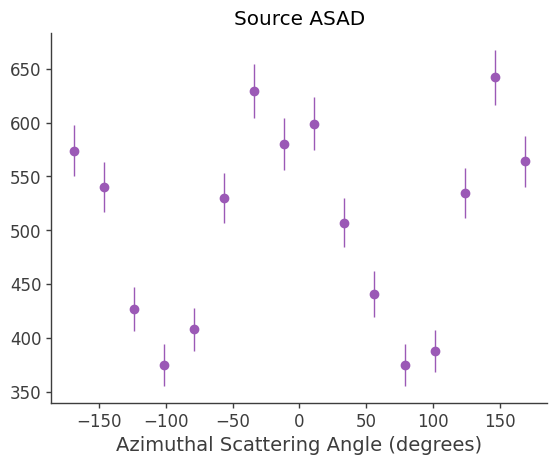

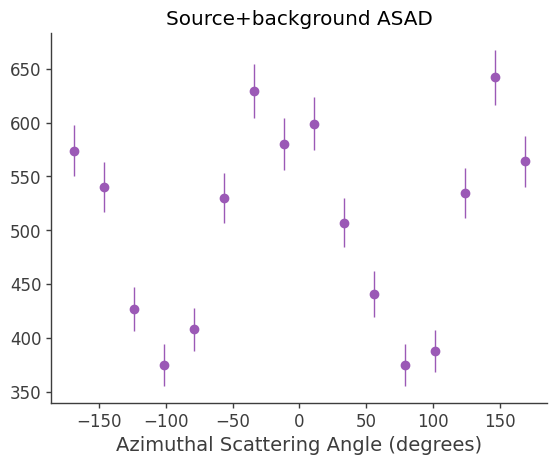

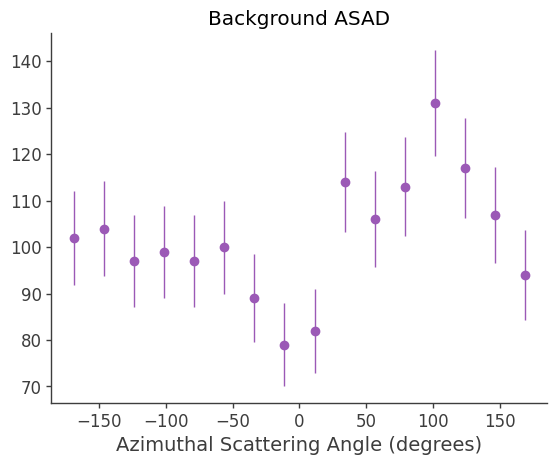

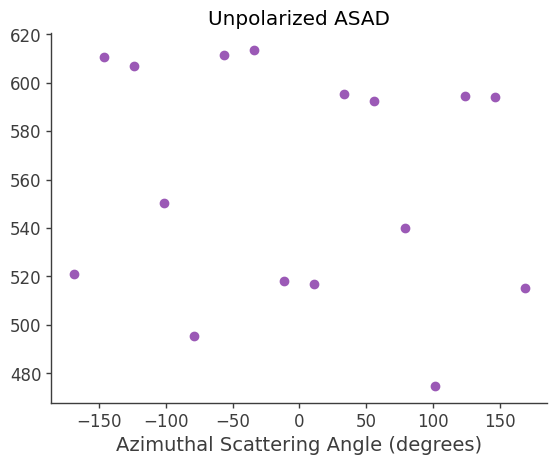

In [ ]:
attitude = sc_orientation.get_attitude()[0]
source_direction_local = source_direction.transform_to(SpacecraftFrame(attitude=attitude))

grb_polarization_local = PolarizationASAD(source_direction_local, spectrum, asad_bin_edges, data, background, sc_orientation, response_file, response_convention='RelativeX', show_plots=True, fit_convention=MEGAlibRelativeX(attitude=attitude))

Perform the fit in spacecraft coordinates.

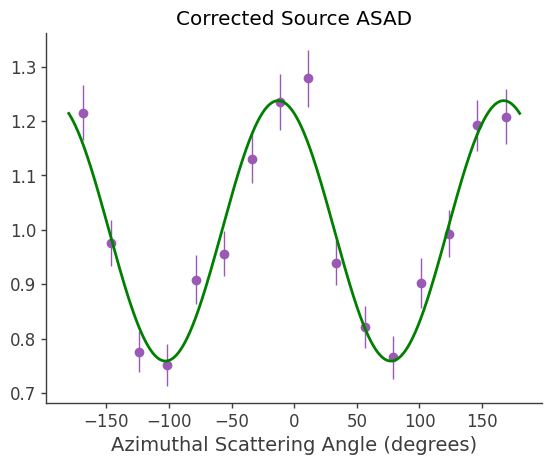

Best fit polarization fraction: 0.91 +/- 0.07
Minimum detectable polarization: 0.181
Best fit polarization angle (IAU convention): 87.222 +/- 2.107


In [21]:
polarization_local_fit = grb_polarization_local.fit(show_plots=True)

print('Best fit polarization fraction:', round(polarization_local_fit['fraction'], 3), '+/-', round(polarization_local_fit['fraction uncertainty'], 3))
print('Minimum detectable polarization:', round(grb_polarization_local._mdp, 3))
print('Best fit polarization angle (IAU convention):', round(polarization_local_fit['angle'].angle.degree, 3), '+/-', round(polarization_local_fit['angle uncertainty'].degree, 3))

The fitted polarization angle is always output in the IAU convention, but can easily be transformed to other conventions.

In [22]:
print('RelativeX:', round(polarization_local_fit['angle'].transform_to(MEGAlibRelativeX(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeY:', round(polarization_local_fit['angle'].transform_to(MEGAlibRelativeY(attitude=attitude)).angle.degree, 3), 'degrees')
print('RelativeZ:', round(polarization_local_fit['angle'].transform_to(MEGAlibRelativeZ(attitude=attitude)).angle.degree, 3), 'degrees')
print('IAU:', round(polarization_local_fit['angle'].transform_to(IAUPolarizationConvention()).angle.degree, 3), 'degrees')

RelativeX: 77.219 degrees
RelativeY: 167.218 degrees
RelativeZ: 77.211 degrees
IAU: 87.222 degrees
